# Make dataset from parse trees for input to PYG

A graph is used to model pairwise relations (edges) between objects (nodes). A single graph in PyG is described by an instance of `torch_geometric.data.Data`, which holds the following attributes by default:

* __data.x__: Node feature matrix with shape `[num_nodes, num_node_features]`

* __data.edge_index__: Graph connectivity in `COO` format with shape `[2, num_edges]` and type `torch.long`

* __data.edge_attr__: Edge feature matrix with shape `[num_edges, num_edge_features]`

* __data.y__: Target to train against (may have arbitrary shape), e.g., node-level targets of shape `[num_nodes, *]` or graph-level targets of shape `[1, *]`

* __data.pos__: Node position matrix with shape `[num_nodes, num_dimensions]`

In [1]:
!conda info --envs

# conda environments:
#
base                     /Users/kylehamilton/opt/anaconda3
torch                 *  /Users/kylehamilton/opt/anaconda3/envs/torch



In [1]:
import torch

In [2]:
from torch_geometric.data import Data

In [3]:
from collections import defaultdict

In [6]:
import benepar, spacy
nlp = spacy.load('en_core_web_md')
from benepar import BeneparComponent, NonConstituentException
# nlp.add_pipe(BeneparComponent("benepar_en3"))
nlp.add_pipe('benepar', config={'model': 'benepar_en3'})

In [7]:
# https://tedboy.github.io/nlps/generated/generated/nltk.ParentedTree.html
import nltk
from nltk import Tree, ParentedTree, CFG

In [17]:
text = "If he crosses, he joins Bush II in the history books."

In [330]:
def d(text):
    doc = nlp(text)
    sent = list(doc.sents)[0]
    parse_tree = Tree.fromstring('(' + sent._.parse_string + ')')
    parse_string = sent._.parse_string
    return (parse_tree, parse_string)

In [331]:
pt = d(text)[0]

In [333]:
pt.productions()

[ -> S,
 S -> SBAR , NP VP .,
 SBAR -> IN S,
 IN -> 'If',
 S -> NP VP,
 NP -> PRP,
 PRP -> 'he',
 VP -> VBZ,
 VBZ -> 'crosses',
 , -> ',',
 NP -> PRP,
 PRP -> 'he',
 VP -> VBZ NP PP,
 VBZ -> 'joins',
 NP -> NNP NNP,
 NNP -> 'Bush',
 NNP -> 'II',
 PP -> IN NP,
 IN -> 'in',
 NP -> DT NN NNS,
 DT -> 'the',
 NN -> 'history',
 NNS -> 'books',
 . -> '.']

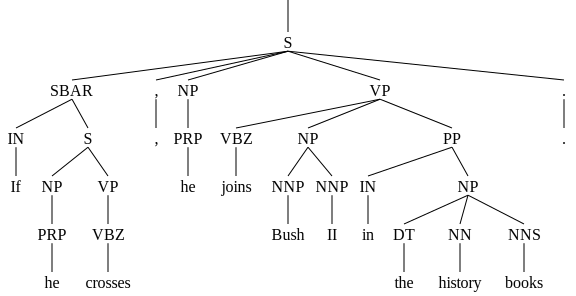

In [334]:
pt

## 1. Convert Tags to node indexes

In [20]:
nodes_dict = defaultdict(int)

sent_parse = d(text)[1]
new_string = ""

idx = 0

for item in sent_parse.split(" "):
    if item.startswith('('):
        nodes_dict[idx]=item[1:]
        new_string+='('+str(idx)+" "
        idx += 1
    else:
        new_string+=item+" "

new_string.strip()

'(0 (1 (2 If) (3 (4 (5 he)) (6 (7 crosses)))) (8 ,) (9 (10 he)) (11 (12 joins) (13 (14 Bush) (15 II)) (16 (17 in) (18 (19 the) (20 history) (21 books)))) (22 .))'

In [21]:
nodes_dict

defaultdict(int,
            {0: 'S',
             1: 'SBAR',
             2: 'IN',
             3: 'S',
             4: 'NP',
             5: 'PRP',
             6: 'VP',
             7: 'VBZ',
             8: ',',
             9: 'NP',
             10: 'PRP',
             11: 'VP',
             12: 'VBZ',
             13: 'NP',
             14: 'NNP',
             15: 'NNP',
             16: 'PP',
             17: 'IN',
             18: 'NP',
             19: 'DT',
             20: 'NN',
             21: 'NNS',
             22: '.'})

## 2. Generate a parse tree given the new string where tags have been replaced with node ids

In [22]:
t = Tree.fromstring(new_string)

## 3. Convert the tree to a list of edges of the form (source_node, destination_node)
* First, get the productions
* Next, convert productions to edges

In [23]:
print(t.productions())

[0 -> 1 8 9 11 22, 1 -> 2 3, 2 -> 'If', 3 -> 4 6, 4 -> 5, 5 -> 'he', 6 -> 7, 7 -> 'crosses', 8 -> ',', 9 -> 10, 10 -> 'he', 11 -> 12 13 16, 12 -> 'joins', 13 -> 14 15, 14 -> 'Bush', 15 -> 'II', 16 -> 17 18, 17 -> 'in', 18 -> 19 20 21, 19 -> 'the', 20 -> 'history', 21 -> 'books', 22 -> '.']


In [24]:
def convertToEdgeList(tree):
    """
    input: NLTK Tree
    output: list of tuples of edges of the form (source_node, destination_node)
    """
    
    edge_list = []
    for production in tree.productions():
        for elem in production.rhs():
            if type(elem) is not str and production.lhs().symbol() != "":
                edge_list.append([int(str(production.lhs())), int(str(elem))])

    return edge_list

In [25]:
edges = convertToEdgeList(t)
edges

[[0, 1],
 [0, 8],
 [0, 9],
 [0, 11],
 [0, 22],
 [1, 2],
 [1, 3],
 [3, 4],
 [3, 6],
 [4, 5],
 [6, 7],
 [9, 10],
 [11, 12],
 [11, 13],
 [11, 16],
 [13, 14],
 [13, 15],
 [16, 17],
 [16, 18],
 [18, 19],
 [18, 20],
 [18, 21]]

## 4. Convert node labels (i.e. Tags) to floats
* First, open the file containing all possible tags
* Create two dictionaries tags_to_ids and ids_to_tags
* Convert the node labels to floats using the index of the tag in the tags_to_ids dictionary

In [315]:
# TODO: convert nodes to float - onehot, or embeddings
# if onehot, get all possible POS tags to create table
# http://surdeanu.cs.arizona.edu/mihai/teaching/ista555-fall13/readings/PennTreebankConstituents.html
# https://www.cis.upenn.edu/~bies/manuals/root.pdf

tags_to_ids = defaultdict(str)
ids_to_tags = defaultdict(int)

with open('pennTreeBankTags.txt','r') as _f:
    lines = _f.readlines()
    for idx,line in enumerate(lines):
        ids_to_tags[idx]=line.strip()
        tags_to_ids[line.strip()]=idx
        
print(tags_to_ids)
# print(ids_to_tags)

defaultdict(<class 'str'>, {'ADJP': 0, '-ADV': 1, 'ADVP': 2, '-BNF': 3, 'CC': 4, 'CD': 5, '-CLF': 6, '-CLR': 7, 'CONJP': 8, '-DIR': 9, 'DT': 10, '-DTV': 11, 'EX': 12, '-EXT': 13, 'FRAG': 14, 'FW': 15, '-HLN': 16, 'IN': 17, 'INTJ': 18, 'JJ': 19, 'JJR': 20, 'JJS': 21, '-LGS': 22, '-LOC': 23, 'LS': 24, 'LST': 25, 'MD': 26, '-MNR': 27, 'NAC': 28, 'NN': 29, 'NNS': 30, 'NNP': 31, 'NNPS': 32, '-NOM': 33, 'NP': 34, 'NX': 35, 'PDT': 36, 'POS': 37, 'PP': 38, '-PRD': 39, 'PRN': 40, 'PRP': 41, '-PRP': 42, 'PRP$': 43, 'PRP-S': 44, 'PRT': 45, '-PUT': 46, 'QP': 47, 'RB': 48, 'RBR': 49, 'RBS': 50, 'RP': 51, 'RRC': 52, 'S': 53, 'SBAR': 54, 'SBARQ': 55, '-SBJ': 56, 'SINV': 57, 'SQ': 58, 'SYM': 59, '-TMP': 60, 'TO': 61, '-TPC': 62, '-TTL': 63, 'UCP': 64, 'UH': 65, 'VB': 66, 'VBD': 67, 'VBG': 68, 'VBN': 69, 'VBP': 70, 'VBZ': 71, '-VOC': 72, 'VP': 73, 'WDT': 74, 'WHADJP': 75, 'WHADVP': 76, 'WHNP': 77, 'WHPP': 78, 'WP': 79, 'WP$': 80, 'WP-S': 81, 'WRB': 82, ',': 83, '.': 84, 'X': 85})


## NOTE
Note that it is necessary that the elements in edge_index only hold indices in the range { 0, ..., num_nodes - 1}. This is needed as we want our final data representation to be as compact as possible, e.g., we want to index the source and destination node features of the first edge (0, 1) via x[0] and x[1], respectively. You can always check that your final Data objects fulfill these requirements by running validate():

data.validate(raise_on_error=True)

edges = 
```
[[0, 1],
 [0, 8]
 ...
]
```
nodes_dict = 
```
{0: 'S',
 1: 'SBAR',
 2: 'IN',
 3: 'S',
 ...
 8: ',',
 9: 'NP',
 ...
}
```

nodes_ids == x
```
x[0] -> 'S' -> embed('S') -> [...]
x[1] -> 'SBAR'
x[2] -> 'IN'
x[3] -> 'S'
...
x[8] -> ','
...
```

In [318]:
nodes_ids = [[tags_to_ids[v]/100] if v in tags_to_ids.keys() else [0.83] for k,v in nodes_dict.items()]

In [319]:
nodes_ids

[[0.53],
 [0.54],
 [0.17],
 [0.53],
 [0.34],
 [0.41],
 [0.73],
 [0.71],
 [0.83],
 [0.34],
 [0.41],
 [0.73],
 [0.71],
 [0.34],
 [0.31],
 [0.31],
 [0.38],
 [0.17],
 [0.34],
 [0.1],
 [0.29],
 [0.3],
 [0.84]]

In [322]:
import pandas as pd
df = pd.read_csv("unknown_tags_val.csv")

In [326]:
for t in set(df['TAG']):
    print(t)

``
-RRB-
HYPH
''
NFP
-LRB-
NML
:
$


# TODO
Use FastText to generate POS tag embeddings
* Convert text to parse strings
* Train FastText on parse strings to obtain embeddings

In [30]:
unknown_tags = []
nodes_ids = []
for n in nodes:
    if n not in tags_to_ids.keys():
        unknown_tags.append(n)
        nodes_ids.append([83])
    else:
        nodes_ids.append([tags_to_ids[n]])
 

In [311]:
import csv
with open('unknown_tags_test.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(['TAG']) #header
    write.writerows(unknown_tags)

In [30]:
names=['Appeal_to_Authority',
     'Appeal_to_fear-prejudice',
     'Bandwagon',
     'Black-and-White_Fallacy',
     'Causal_Oversimplification',
     'Doubt',
     'Exaggeration,Minimisation',
     'Flag-Waving',
     'Loaded_Language',
     'Name_Calling,Labeling',
     'Obfuscation,Intentional_Vagueness,Confusion',
     'Red_Herring',
     'Reductio_ad_hitlerum',
     'Repetition',
     'Slogans',
     'Straw_Men',
     'Thought-terminating_Cliches',
     'Whataboutism',
     'Not_Propaganda']

## 5. Create a PYG dataset

In [86]:
edge_index = torch.tensor(edges, dtype=torch.long)

x = torch.tensor(nodes_ids, dtype=torch.float)
y = torch.tensor([names.index("Bandwagon")], dtype=torch.long)


datum = Data(x=x, y=y, edge_index=edge_index.t().contiguous())

In [87]:
datum

Data(x=[23, 1], edge_index=[2, 22], y=[1])

In [33]:
datum.is_directed()

True

### In the next section : make a list of all datapoints, and save it using DataLoader and Dataset
* data_list = [datum1, datum2, ..., datumN]
* loader = DataLoader(data_list, batch_size=32)
* data, slices = Dataset.collate(data_list)
* torch.save((data, slices), 'data/ptc_trees_sample.pt')

## 6. Do it for the whole dataset
#### See the makePYGdata.py script

In [291]:
import torch
from torch_geometric.data import Data, DataLoader, InMemoryDataset, download_url
import makePYGdata as mpd
import importlib
importlib.reload(mpd)

<module 'makePYGdata' from '/Users/kylehamilton/MyDocuments/ML-Labs/propaganda-detection/GNN/makePYGdata.py'>

In [292]:
some_data = mpd.PTC_Trees_Dataset(root='data_undirected')

Processing...
Found cached dataset parquet (/Users/kylehamilton/.cache/huggingface/datasets/Kyleiwaniec___parquet/Kyleiwaniec--PTC_Corpus-dc238a4991580b39/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /Users/kylehamilton/.cache/huggingface/datasets/Kyleiwaniec___parquet/Kyleiwaniec--PTC_Corpus-dc238a4991580b39/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-aad3be4b871c993a_*_of_00004.arrow
Loading cached processed dataset at /Users/kylehamilton/.cache/huggingface/datasets/Kyleiwaniec___parquet/Kyleiwaniec--PTC_Corpus-dc238a4991580b39/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-910b135e91c33b38_*_of_00004.arrow
Loading cached processed dataset at /Users/kylehamilton/.cache/huggingface/datasets/Kyleiwaniec___parquet/Kyleiwaniec--PTC_Corpus-dc238a4991580b39/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-9d6dfebae211e075_*_of_00004.arrow
processing sentence:: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4083/4083 [10:23<00:00,  6.55it/s]
Done!


In [293]:
some_data

PTC_Trees_Dataset(20584)

In [294]:
# print(vars(some_data))

In [295]:
print(dir(some_data))

['__add__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_data_list', '_download', '_indices', '_infer_num_classes', '_is_protocol', '_process', 'collate', 'copy', 'data', 'download', 'get', 'get_summary', 'index_select', 'indices', 'len', 'log', 'num_classes', 'num_edge_features', 'num_features', 'num_node_features', 'pre_filter', 'pre_transform', 'print_summary', 'process', 'processed_dir', 'processed_file_names', 'processed_paths', 'raw_dir', 'raw_file_names', 'raw_paths', 'root', 'shuffle', 'slices', 'transform']


In [296]:
print(some_data.len())

20584


In [297]:
loader = DataLoader(some_data, batch_size=1)

In [298]:
print(dir(loader))

['_DataLoader__initialized', '_DataLoader__multiprocessing_context', '_IterableDataset_len_called', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_auto_collation', '_dataset_kind', '_get_iterator', '_get_shared_seed', '_index_sampler', '_is_protocol', '_iterator', 'batch_sampler', 'batch_size', 'check_worker_number_rationality', 'collate_fn', 'dataset', 'drop_last', 'exclude_keys', 'follow_batch', 'generator', 'multiprocessing_context', 'num_workers', 'persistent_workers', 'pin_memory', 'pin_memory_device', 'prefetch_factor', 'sampler', 'timeout', 'worker_init_fn']


In [299]:
print(dir(loader.dataset))

['__add__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_data_list', '_download', '_indices', '_infer_num_classes', '_is_protocol', '_process', 'collate', 'copy', 'data', 'download', 'get', 'get_summary', 'index_select', 'indices', 'len', 'log', 'num_classes', 'num_edge_features', 'num_features', 'num_node_features', 'pre_filter', 'pre_transform', 'print_summary', 'process', 'processed_dir', 'processed_file_names', 'processed_paths', 'raw_dir', 'raw_file_names', 'raw_paths', 'root', 'shuffle', 'slices', 'transform']


In [300]:
print(dir(loader.dataset.data))

['__call__', '__cat_dim__', '__class__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__inc__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_all_edges_to_layout', '_edge_attr_cls', '_edge_to_layout', '_get_edge_index', '_get_tensor', '_get_tensor_size', '_multi_get_tensor', '_put_edge_index', '_put_tensor', '_remove_tensor', '_store', '_tensor_attr_cls', '_to_type', 'apply', 'apply_', 'batch', 'clone', 'coalesce', 'contains_isolated_nodes', 'contains_self_loops', 'contiguous', 'coo', 'cpu', 'csc', 'csr', 'cuda', 'debug', 'detach', 'detach_', 'edge_attr', 'edge_index', 'edge_stores', 'edge_w

In [301]:
loader.dataset.data['y']

tensor([18,  9,  8,  ...,  7, 18, 18])

In [302]:
loader.dataset.data['x'][:5]

tensor([[0.3400],
        [0.3400],
        [0.8300],
        [0.8300],
        [0.3100]])

In [303]:
loader.dataset.data['split']

tensor([0, 0, 0,  ..., 2, 2, 2], dtype=torch.uint8)

In [304]:
loader.dataset.num_classes

19

In [305]:
loader.dataset.data.keys

['y', 'split', 'x', 'edge_index']

In [306]:
loader.dataset.data['edge_index']

tensor([[ 0,  1,  0,  ...,  7,  6,  8],
        [ 1,  0, 11,  ...,  6,  8,  6]])

In [307]:
loader.dataset.data.is_undirected()

True

In [308]:
pyg_dataset = loader.dataset

In [309]:
pyg_dataset[0]

Data(x=[14, 1], edge_index=[2, 26], y=[1], split=[1])